In [1]:
import os
import sys

import yaml

import numpy as np
import torch
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import gridspec

from osgeo import gdal

sys.path.append('/home/ccollado/2_phileo_fm/phileo-bench')
from training_script import main as train_model

In [2]:
def decode_latitude(encoded_sin, encoded_cos):
    """
    Decode latitude from its encoded sine and cosine components.
    """
    # Invert the normalization: recover the original sine and cosine values
    sin_val = 2 * encoded_sin - 1
    cos_val = 2 * encoded_cos - 1

    # Compute the angle using arctan2, ensuring it lies in [0, 2π)
    angle = np.arctan2(sin_val, cos_val)
    angle = np.mod(angle, 2 * np.pi)  # ensure angle is non-negative

    # Convert angle back to latitude range [-90, 90]
    # Recall: angle = 2π * (lat_adj / 180) where lat_adj = lat + 90
    lat_adj = angle / (2 * np.pi) * 180.0
    lat = lat_adj - 90.0

    return lat

def decode_longitude(encoded_sin, encoded_cos):
    """
    Decode longitude from its encoded sine and cosine components.
    """
    # Invert the normalization: recover the original sine and cosine values
    sin_val = 2 * encoded_sin - 1
    cos_val = 2 * encoded_cos - 1

    # Compute the angle using arctan2, ensuring it lies in [0, 2π)
    angle = np.arctan2(sin_val, cos_val)
    angle = np.mod(angle, 2 * np.pi)  # ensure angle is non-negative

    # Convert angle back to longitude range [-180, 180]
    # Recall: angle = 2π * (lng_adj / 360) where lng_adj = lng + 180
    lng_adj = angle / (2 * np.pi) * 360.0
    lng = lng_adj - 180.0

    return lng

def decode_coordinates(encoded_coords):
    """
    Decode an array of encoded coordinates.
    Assumes `encoded_coords` has shape (n, 4) where each row is 
    [sin_lat, cos_lat, sin_lon, cos_lon].
    Returns an array of shape (n, 2) containing the decoded [lat, lon].
    """
    # Extract the individual encoded components for latitude and longitude
    encoded_sin_lat = encoded_coords[:, 0]
    encoded_cos_lat = encoded_coords[:, 1]
    encoded_sin_lon = encoded_coords[:, 2]
    encoded_cos_lon = encoded_coords[:, 3]

    # Decode each component
    lat = decode_latitude(encoded_sin_lat, encoded_cos_lat)
    lon = decode_longitude(encoded_sin_lon, encoded_cos_lon)

    # Stack the decoded latitudes and longitudes into an (n, 2) array
    return np.column_stack((lat, lon))




def encode_latitude(lat):
    """ Latitude goes from -90 to 90 """
    lat_adj = lat + 90.0
    lat_max = 180

    encoded_sin = ((np.sin(2 * np.pi * (lat_adj / lat_max)) + 1)) / 2.0
    encoded_cos = ((np.cos(2 * np.pi * (lat_adj / lat_max)) + 1)) / 2.0

    return np.array([encoded_sin, encoded_cos], dtype=np.float32)


def encode_longitude(lng):
    """ Longitude goes from -180 to 180 """
    lng_adj = lng + 180.0
    lng_max = 360

    encoded_sin = ((np.sin(2 * np.pi * (lng_adj / lng_max)) + 1)) / 2.0
    encoded_cos = ((np.cos(2 * np.pi * (lng_adj / lng_max)) + 1)) / 2.0

    return np.array([encoded_sin, encoded_cos], dtype=np.float32)

def encode_coordinates(coords):
    lat_values = coords[:, 0]
    lon_values = coords[:, 1]
    encoded_lat = encode_latitude(lat_values)
    encoded_lon = encode_longitude(lon_values)
    encoded_coords = np.concatenate((encoded_lat, encoded_lon), axis=0)
    encoded_coords = np.transpose(encoded_coords)
    return encoded_coords


def plot_map(ax, label, prediction):
    """
    Plots the map with the label and prediction coordinates on the given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot the map.
        label (tuple): A tuple containing (latitude, longitude) of the true label.
        prediction (tuple): A tuple containing (latitude, longitude) of the prediction.
    """
    lat_label, lon_label = label
    lat_pred, lon_pred = prediction

    ax.set_global()
    ax.set_facecolor("white")
    ax.coastlines(color='black', linewidth=1)

    # Plot the true label
    ax.plot(
        lon_label, lat_label,
        marker='o',
        markersize=15,
        markeredgecolor='black',
        markerfacecolor='green',
        alpha=0.7,
        transform=ccrs.PlateCarree(),
        label=f"Label ({lat_label:.3f}, {lon_label:.3f})"
    )

    # Plot the prediction
    ax.plot(
        lon_pred, lat_pred,
        marker='o',
        markersize=15,
        markeredgecolor='black',
        markerfacecolor='red',
        alpha=0.7,
        transform=ccrs.PlateCarree(),
        label=f"Prediction ({lat_pred:.3f}, {lon_pred:.3f})"
    )


In [18]:
def get_random_sample(dataloader, model, device='cuda'):
    """
    Randomly selects a sample from the given dataloader without materializing all data in memory.
    Computes the difference between the true label and the model's output.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader to sample from.
        model (torch.nn.Module): The PyTorch model.
        device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
        dict: A dictionary containing the random sample, true label, model output, 
              and the difference between label and output.
    """
    # Ensure the dataloader is not empty
    if len(dataloader) == 0:
        raise ValueError("The provided DataLoader is empty.")

    # Get a random index
    random_idx = random.randint(0, len(dataloader.dataset) - 1)
    x, y = dataloader.dataset[random_idx]
    y = y['coords']
    x = x.unsqueeze(0).to(device)

    if x.size(0) == 0:
        raise ValueError("The selected batch is empty.")

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(x)

    # Compute the difference
    diff = y - output.cpu().squeeze().numpy()
    
    return {
        "sample": x.cpu().squeeze().numpy(),
        "true_label": y.unsqueeze(0).numpy(),
        "output": output.cpu().numpy(),
        "difference": diff
    }


def new_inference(dataloader, model, device='cuda'):
    """
    Performs inference on a random sample from the dataloader, plots the map and the analyzed image side by side,
    with adjustments to spacing and framing.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader to sample from.
        model (torch.nn.Module): The PyTorch model.
        device (str): The device to run the model on ('cuda' or 'cpu').
    """
    # Get a random sample and perform inference
    result = get_random_sample(dataloader, model, device)
    
    # Decode the true label and prediction coordinates
    coord_label = decode_coordinates(result["true_label"])
    coord_prediction = decode_coordinates(result["output"])
    
    # Prepare the RGB image
    rgb_array = result['sample'][[2, 1, 0], :].transpose(1, 2, 0)
    rgb_array = np.clip(0.5 / rgb_array.mean() * rgb_array, 0, 1)
    
    # Create a figure with GridSpec
    fig = plt.figure(figsize=(16, 8), constrained_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.025, figure=fig)  # Reduced wspace to bring elements closer
    
    # Plot the map on the first subplot
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    plot_map(ax_map, coord_label.squeeze(), coord_prediction.squeeze())
    
    # Add legend directly below the map
    handles, labels = ax_map.get_legend_handles_labels()
    ax_map.legend(
        handles, labels,
        loc='lower center',  # Adjust location to lower center for closer proximity
        bbox_to_anchor=(0.5, -0.1),  # Adjust anchor to bring the legend closer
        ncol=2,
        frameon=False,
        fontsize=14
    )
    
    # Plot the image on the second subplot
    ax_img = fig.add_subplot(gs[1])
    ax_img.imshow(rgb_array)
    ax_img.axis('off')  # Turn off the axes
    ax_img.set_title("Analyzed Image", fontsize=14)
    
    plt.show()
    
    return result, rgb_array


In [4]:
# Load the YAML file
with open('/home/ccollado/2_phileo_fm/phileo-bench/args/pretrain/plot_on_map.yml', 'r') as file:
    config = yaml.safe_load(file)

dl_train, dl_val, dl_test, dl_inference, trainer = train_model(**config)

DEVICE cpu
--------------------------------
split_ratio: 0.005
--------------------------------
train split: taking 41 files out of 8359 in total
Validation data from different tiff files
val split: taking 12 files out of 2415 in total
Dataset protocol:  128_10m
Training set datapoint shape: X - (64, 128, 128, 8)
Validation set datapoint shape: X - (64, 128, 128, 8)
Test set datapoint shape: X - (64, 128, 128, 8)
Inference set datapoint shape: X - (64, 128, 128, 8)
Augmentations: True, Data Parallel: False, generator_device: cpu
Length of training dataloader: 2609
Length of validation dataloader: 768
Length of test dataloader: 76276
Length of inference dataloader: 76276
Training on: FoundationModel4Task_nano
--------------------
Model moved to CPU after summary
Class Weights: tensor([0.1382, 0.4556, 0.4214, 0.2016, 0.1579, 0.2592, 0.2630, 0.2319, 0.6345,
        0.7144, 5.3843, 0.3661, 0.5229, 6.3566, 0.2984, 0.4835, 2.5092, 1.5305,
        0.8965, 0.5635, 2.8361, 0.5816, 0.6152, 0.380

/home/ccollado/miniconda3/envs/phileo_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Estimating initial sigmas:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Initial losses: {'reconstruction': 0.027045496739447117, 'perceptual': 1.408296573162079, 'climate_segmentation': 3.9075503587722777, 'total_variation': 0.0003558851560228504, 'geolocation': 0.19206755980849266}
Initializing scales of individual losses
Initializing log variances of each loss


In [5]:
from collections import OrderedDict

model = trainer.model

weights_path = '/home/ccollado/2_phileo_fm/models/pretrained/4TFM/FoundationModel4Task_best.pt'

foundation_state_dict = torch.load(weights_path, map_location="cpu")

new_state_dict = OrderedDict()
for key, val in foundation_state_dict.items():
    # Remove "module." if it exists
    if key.startswith("module."):
        new_key = key[len("module."):]
    else:
        new_key = key
    
    # Skip keys that contain "zoom"
    if "zoom" in new_key:
        continue
    
    new_state_dict[new_key] = val

model.load_state_dict(new_state_dict, strict=True)

<All keys matched successfully>

In [6]:
import torch.nn as nn

class GeolocationModelWrapper(nn.Module):
    def __init__(self, foundation_model):
        super().__init__()
        self.foundation_model = foundation_model

    def forward(self, x):
        # Use only the geolocation prediction path
        # Run through stem and encoder to get pooled features
        x = self.foundation_model.stem(x)
        bottom_feats, _ = self.foundation_model.encoder(x)
        pooled_feats = bottom_feats.mean(dim=(2, 3))  # Global average pooling
        geo_pred = self.foundation_model.head_geo(pooled_feats)  # Geolocation head
        return geo_pred

geo_model = GeolocationModelWrapper(model)

In [7]:
geo_model.eval()  # Set to evaluation mode
test_input = torch.randn(1, 8, 128, 128)  # Example input with shape (B, 8, 128, 128)
geo_output = geo_model(test_input)
geo_output.shape

torch.Size([1, 4])

In [8]:
x, y = dl_train.dataset[0]
x.shape

torch.Size([8, 128, 128])

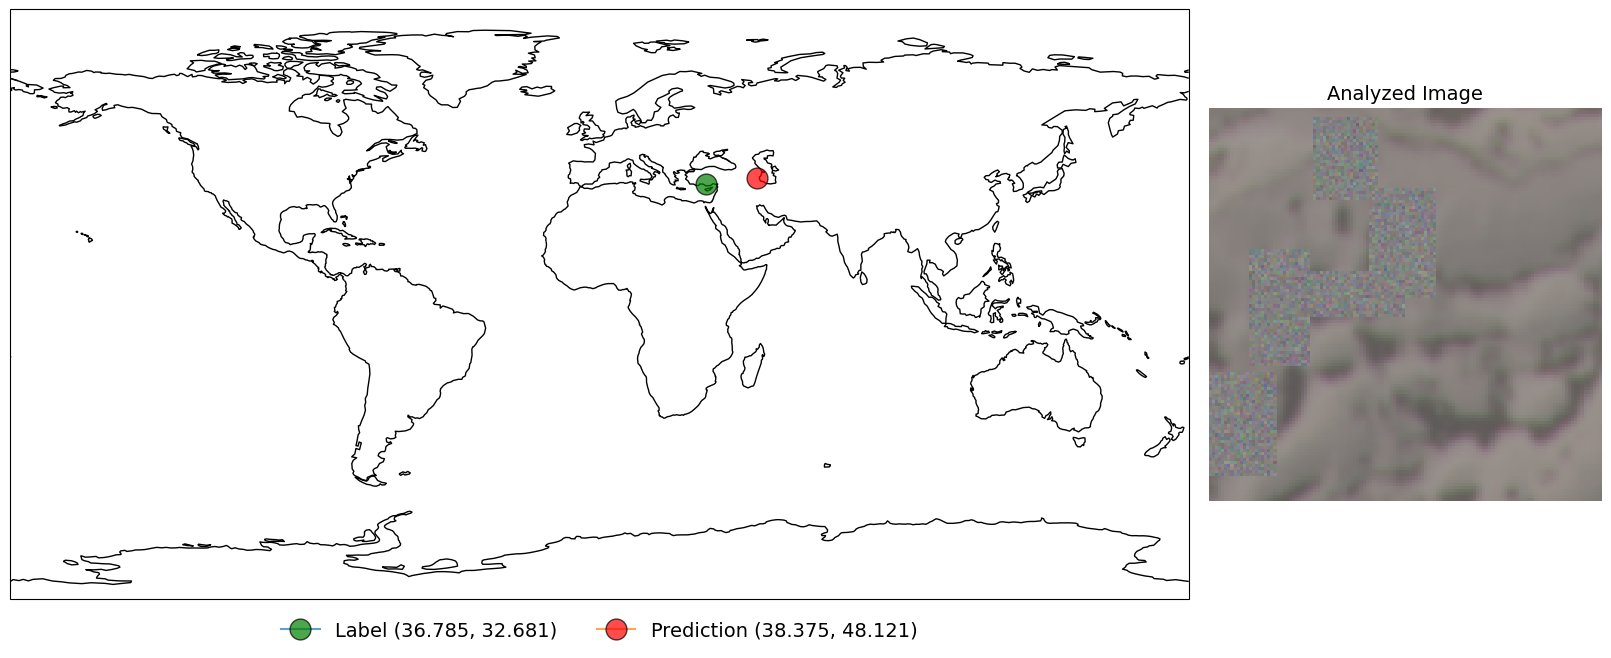

In [42]:
result, rgb_array = new_inference(dl_test, geo_model, device='cpu')